In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cryptovision.tools as tools
from tensorflow.keras import layers
import tensorflow.keras.applications as keras_apps

2025-02-08 00:14:15.912 | INFO     | cryptovision.config:<module>:15 - PROJ_ROOT path is: /Users/leonardo/Documents/Projects/cryptovision


In [2]:
df = pd.read_csv(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v3.0.0/image_catalog_clean.csv'
)

SEED = 42

df_eviota = df[df['genus'] == 'Eviota']

def clean_dataframe(df, sample_limit):
    # Rmv duplicates
    df = df.drop_duplicates(subset='hash', keep='first')

    # Rmv Species with less than few images
    df = df[df['species'].map(df['species'].value_counts()) > sample_limit]
    
    df.reset_index(drop=True, inplace=True)
    
    return df

df_eviota = clean_dataframe(df_eviota, 50)

train_df, val_df, test_df = tools.split_dataframe(
    df_eviota,
    test_size=0.15,
    val_size=0.15,
    stratify_by='folder_label',
    random_state=SEED,
)

train_ds = tools.tensorflow_dataset(
    train_df,
    batch_size=128,
    image_size=(224, 224),
)

val_ds = tools.tensorflow_dataset(
    val_df,
    batch_size=128,
    image_size=(224, 224),
)


2025-02-08 00:14:19.956391: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-02-08 00:14:19.956419: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-02-08 00:14:19.956422: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-02-08 00:14:19.956622: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-08 00:14:19.956636: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
train_ds_sp = train_ds.map(lambda image, labels: (image, labels['species']))
val_ds_sp = val_ds.map(lambda image, labels: (image, labels['species']))

In [4]:
augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal", seed=SEED),
        layers.RandomRotation(0.1, seed=SEED),
        layers.RandomZoom(height_factor=(0.05, 0.1), width_factor=(0.05, 0.1), seed=SEED),  # Wider zoom range
        layers.RandomContrast(0.2, seed=SEED),
        layers.RandomBrightness(0.2, seed=SEED),
        layers.RandomTranslation(0.1, 0.1, seed=SEED),
        #layers.RandomCrop(SETUP['image']['size'][0], SETUP['image']['size'][1], seed=SEED),
        layers.GaussianNoise(0.1, seed=SEED),
    ],
    name='augmentation'
)

In [12]:
pretrain = keras_apps.ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
pretrain.trainable = False

def pretrain_model(backbone, preprocess, input_shape=(224, 224, 3), name=None, augmentation=None):
    
    inputs = layers.Input(shape=input_shape, name='input_layer')
    x = augmentation(inputs) if augmentation else inputs
    x = preprocess(x)
    x = backbone(x, training=False)
    
    return tf.keras.Model(inputs, x, name=name)

def dense_block(input_layer, name:str, units:int, dropout:float, activation:str='relu', norm:bool=True):
    
    x = layers.Dense(units, name=name)(input_layer)
    if norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout)(x)
    return x

feature_extractor = pretrain_model(
    pretrain, 
    keras_apps.resnet_v2.preprocess_input, 
    input_shape=(224, 224, 3), 
    name='feature_extractor',
    augmentation=augmentation
)

# Eviota Model
features = layers.GlobalAveragePooling2D(name='GlobAvgPool2D')(feature_extractor.output)

hidden_layer = dense_block(features, 'hidden_layer_1', 128, 0.3)

hidden_layer_1 = dense_block(hidden_layer, 'hidden_layer_2', 64, 0.3)

# Species Output
species_output = layers.Dense(11, activation='softmax', name='species')(hidden_layer_1)

model = tf.keras.Model(
    feature_extractor.input,
    species_output,
    name='EviotaModel'
)

model.summary()

Model: "EviotaModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_9 (Cast)                   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_4 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_4 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GlobAvgPool2D                   │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ species (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,836,811 (90.93 MB)

 Trainable params: 271,627 (1.04 MB)

 Non-trainable params: 23,565,184 (89.89 MB)

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [14]:
history = model.fit(
    train_ds_sp,
    epochs=20,
    validation_data=val_ds_sp,
    verbose=1,
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 960ms/step - accuracy: 0.1694 - loss: 2.6998 - val_accuracy: 0.4805 - val_loss: 1.6550
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 739ms/step - accuracy: 0.5601 - loss: 1.4432 - val_accuracy: 0.6073 - val_loss: 1.3617
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 742ms/step - accuracy: 0.6826 - loss: 1.1134 - val_accuracy: 0.7049 - val_loss: 1.0681
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 744ms/step - accuracy: 0.7397 - loss: 0.9601 - val_accuracy: 0.7585 - val_loss: 0.8608
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 740ms/step - accuracy: 0.7630 - loss: 0.8182 - val_accuracy: 0.7683 - val_loss: 0.8440
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 744ms/step - accuracy: 0.8039 - loss: 0.7368 - val_accuracy: 0.8049 - val_loss: 0.6955
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 752ms/step - accuracy: 0.8163 - loss: 0.6565 - val_accuracy: 0.8268 - val_loss: 0.6440
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 748ms/step - accuracy: 0.8253 - loss: 0.6104 - val_accu

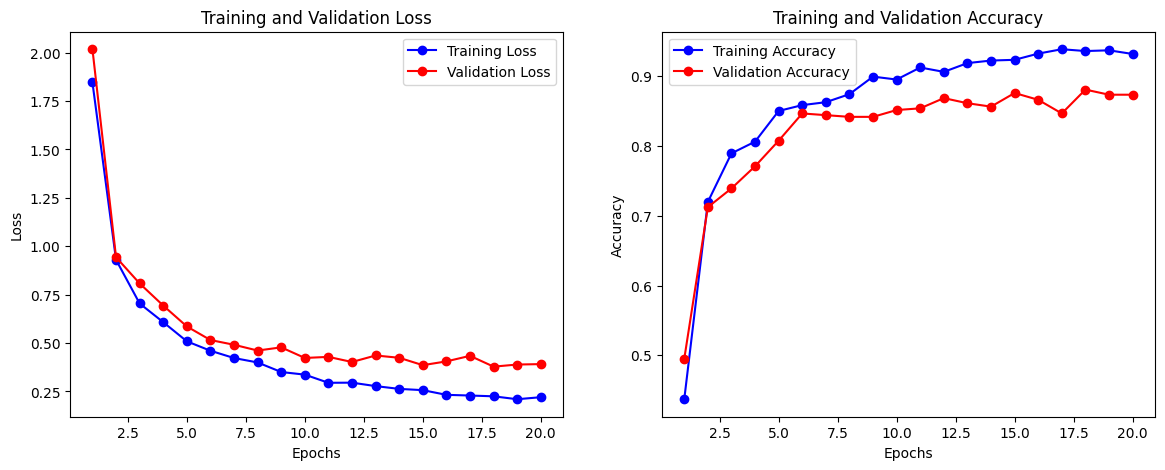

In [10]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss from a Keras History object.
    
    Parameters:
    -----------
    history : keras.callbacks.History
        The History object returned by model.fit().
    """
    # Retrieve metrics from the history object
    acc      = history.history.get('accuracy', [])
    val_acc  = history.history.get('val_accuracy', [])
    loss     = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    
    epochs = range(1, len(loss) + 1)
    
    # Create subplots for loss and accuracy
    plt.figure(figsize=(14, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

# Example usage:
plot_training_history(history)


In [15]:
test_ds = tools.tensorflow_dataset(
    test_df,
    batch_size=128,
    image_size=(224, 224),
)

test_ds_sp = test_ds.map(lambda image, labels: (image, labels['species']))

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

all_true = []
all_pred = []
all_conf = []

#sp_labels = sorted(df_eviota['species'].unique())

for batch in test_ds_sp:
    images, labels = batch
    
    true = tf.argmax(labels, axis=1).numpy()
    pred = model.predict(images, verbose=0)
    
    pred = tf.argmax(pred, axis=1)
    #conf = tf.reduce_max(pred, axis=1)
    
    all_true.extend(true)
    all_pred.extend(pred)
    #all_conf.extend(conf)

2025-02-08 00:47:18.084735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
